# **PROJECT**

## **Cubic Spiline Interpolation Code**

In [1]:
import cv2
import numpy as np
from scipy.interpolate import CubicSpline

def load_video(video_path):
    """ Load video and extract frames. """
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames, fps, width, height

def get_fps(video_path):
    # Capture video from file
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print(f"Failed to open video: {video_path}")
        return None

    # Get FPS from the video file
    fps = video.get(cv2.CAP_PROP_FPS)
    video.release()
    return fps

def interpolate_frames(frame1, frame2, num_inter_frames):
    """ Interpolate frames using cubic spline interpolation. """
    x = np.array([0, 1])  # Normalized positions of original frames
    result_frames = []
    for i in range(num_inter_frames):
        t = (i + 1) / (num_inter_frames + 1)  # Normalized time for interpolation
        inter_frame = np.zeros_like(frame1)
        for c in range(frame1.shape[2]):  # Iterate over color channels
            cs = CubicSpline(x, np.stack([frame1[:, :, c], frame2[:, :, c]], axis=0), axis=0)
            inter_frame[:, :, c] = cs(t)
        result_frames.append(inter_frame)
    return result_frames

def create_high_fps_video(input_path, output_path, frame_rate_multiplier):
    """ Create a high frame rate video from an input video. """
    frames, original_fps, width, height = load_video(input_path)
    num_inter_frames = frame_rate_multiplier - 1

    new_frames = []
    for i in range(len(frames) - 1):
        new_frames.append(frames[i])
        inter_frames = interpolate_frames(frames[i], frames[i+1], num_inter_frames)
        new_frames.extend(inter_frames)
    new_frames.append(frames[-1])  # Add the last frame

    # Output video
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), original_fps * frame_rate_multiplier, (width, height))
    for frame in new_frames:
        out.write(np.uint8(frame))
    out.release()


# Enter the frame rate multiplier to increase the frame rate of the video (e.g., 2 for doubling the frame rate)
frame_rate_multiplier = int(input("Enter frame rate multiplier (To match with Ground Truth multiply 3): "))

# Create high FPS video
create_high_fps_video('input.mp4', 'output_video.mp4', frame_rate_multiplier)


print("Output video is Created")



Enter frame rate multiplier: 3


## **METRICS Function: PSNR and SSIM**

In [2]:
import cv2
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

def load_video_frames(video_path):
    """ Load video and extract grayscale frames. """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(frame)
    cap.release()
    return frames


def compute_metrics(original_frames, interpolated_frames):
    """ Compute SSIM and PSNR metrics between two sets of frames. """
    ssim_scores = []
    psnr_scores = []
    min_length = min(len(original_frames), len(interpolated_frames))
    for i in range(min_length):
        ssim = compare_ssim(original_frames[i], interpolated_frames[i], data_range=interpolated_frames[i].max() - interpolated_frames[i].min())
        psnr = compare_psnr(original_frames[i], interpolated_frames[i])
        ssim_scores.append(ssim)
        psnr_scores.append(psnr)
    return ssim_scores, psnr_scores


### **Metrics Comparison of Input Video vs Interpolated Output Video**

In [3]:
print("Metrics Comparison of Input Video vs Interpolated Output Video")

input_video = load_video_frames('input.mp4')
interpolated_frames = load_video_frames('output_video.mp4')

# Calculate FPS for each video
input_video_fps = get_fps('input.mp4')
output_fps = get_fps('output_video.mp4')


# Compute SSIM and PSNR
ssim_scores, psnr_scores = compute_metrics(input_video, interpolated_frames)

# Print average metrics
print("Average SSIM:", np.mean(ssim_scores))
print("Average PSNR:", np.mean(psnr_scores))
print(f"FPS of input data : {input_video_fps}")
print(f"FPS of output : {output_fps}")


Average SSIM: 0.7427134382270763
Average PSNR: 18.60140404520841
FPS of input data : 10.0
FPS of output : 30.0


### **Metrics Comparison of Ground Truth vs Interpolated Output video**

In [4]:
print("Metrics Comparison of Ground Truth vs Interpolated Output video")

ground_truth = load_video_frames('ground truth.mp4')
interpolated_frames = load_video_frames('output_video.mp4')

# Calculate FPS for each video
ground_truth_fps = get_fps('ground truth.mp4')
output_fps = get_fps('output_video.mp4')


# Compute SSIM and PSNR
ssim_scores, psnr_scores = compute_metrics(ground_truth, interpolated_frames)

# Print average metrics
print("Average SSIM:", np.mean(ssim_scores))
print("Average PSNR:", np.mean(psnr_scores))
print(f"FPS of ground truth : {ground_truth_fps}")
print(f"FPS of output : {output_fps}")


Average SSIM: 0.8649079868778633
Average PSNR: 28.18336162250392
FPS of ground truth : 30.0
FPS of output : 30.0


## **State of Art: Phase-Based Video Frame Interpolation**

In [5]:
import cv2
import numpy as np

def load_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))  # Convert frames to grayscale
    cap.release()
    return frames

def interpolate_frames_phase(frame1, frame2, num_inter_frames):
    # Generate interpolated frames using phase information
    interpolated_frames = []
    dft1 = np.fft.fft2(frame1)
    dft2 = np.fft.fft2(frame2)
    magnitude1, phase1 = np.abs(dft1), np.angle(dft1)
    magnitude2, phase2 = np.abs(dft2), np.angle(dft2)

    for i in range(1, num_inter_frames + 1):
        alpha = i / (num_inter_frames + 1)
        magnitude_interp = (1 - alpha) * magnitude1 + alpha * magnitude2
        phase_interp = (1 - alpha) * phase1 + alpha * phase2
        interp_dft = magnitude_interp * np.exp(1j * phase_interp)
        interp_frame = np.fft.ifft2(interp_dft)
        interpolated_frames.append(np.abs(interp_frame))

    return interpolated_frames

def create_interpolated_video(video_path, output_path, input_fps, output_fps):
    frames = load_video(video_path)
    num_inter_frames = (output_fps // input_fps) - 1

    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), output_fps, (frames[0].shape[1], frames[0].shape[0]), isColor=False)

    for i in range(len(frames) - 1):
        out.write(frames[i].astype(np.uint8))
        inter_frames = interpolate_frames_phase(frames[i], frames[i+1], num_inter_frames)
        for inter_frame in inter_frames:
            out.write(inter_frame.astype(np.uint8))
    out.write(frames[-1].astype(np.uint8))
    out.release()

# Example usage
create_interpolated_video('input.mp4', 'output2_video.mp4', 10, 30)


### **Metrics Comparison of Input Video vs State of Art Output Video**

In [6]:
print("Metrics Comparison of Input Video vs State of Art Output Video")

input_video = load_video_frames('input.mp4')
interpolated_frames = load_video_frames('output2_video.mp4')

# Calculate FPS for each video
input_video_fps = get_fps('input.mp4')
output_fps = get_fps('output2_video.mp4')


# Compute SSIM and PSNR
ssim_scores, psnr_scores = compute_metrics(input_video, interpolated_frames)

# Print average metrics
print("Average SSIM:", np.mean(ssim_scores))
print("Average PSNR:", np.mean(psnr_scores))
print(f"FPS of input data : {input_video_fps}")
print(f"FPS of output : {output_fps}")


Average SSIM: 0.5797801068090334
Average PSNR: 17.859825002995294
FPS of input data : 10.0
FPS of output : 30.0


### **Metrics Comparison of Ground Truth vs State of Art Output Video**

In [7]:
print("Metrics Comparison of Ground Truth vs State of Art Output Video")

ground_truth = load_video_frames('ground truth.mp4')
interpolated_frames = load_video_frames('output2_video.mp4')

# Calculate FPS for each video
ground_truth_fps = get_fps('ground truth.mp4')
output_fps = get_fps('output2_video.mp4')


# Compute SSIM and PSNR
ssim_scores, psnr_scores = compute_metrics(ground_truth, interpolated_frames)

# Print average metrics
print("Average SSIM:", np.mean(ssim_scores))
print("Average PSNR:", np.mean(psnr_scores))
print(f"FPS of ground truth : {ground_truth_fps}")
print(f"FPS of output : {output_fps}")


Average SSIM: 0.6868773358436668
Average PSNR: 27.026372273657095
FPS of ground truth : 30.0
FPS of output : 30.0


### **Metrics Comparison of Spline Output Video vs State of Art Output Video**

In [8]:
print("Metrics Comparison of Spline Output Video vs State of Art Output Video")

output = load_video_frames('output_video.mp4')
output2 = load_video_frames('output2_video.mp4')

# Calculate FPS for each video
output_fps = get_fps('output_video.mp4')
output2_fps = get_fps('output2_video.mp4')


# Compute SSIM and PSNR
ssim_scores, psnr_scores = compute_metrics(output, output2)

# Print average metrics
print("Average SSIM:", np.mean(ssim_scores))
print("Average PSNR:", np.mean(psnr_scores))
print(f"FPS of Spline Output : {output_fps}")
print(f"FPS of State of Art Output : {output2_fps}")


Average SSIM: 0.761030663346944
Average PSNR: 29.387399332660447
FPS of Spline Output : 30.0
FPS of State of Art Output : 30.0


## **Comparison of SSIM and PSNR for Different Data**

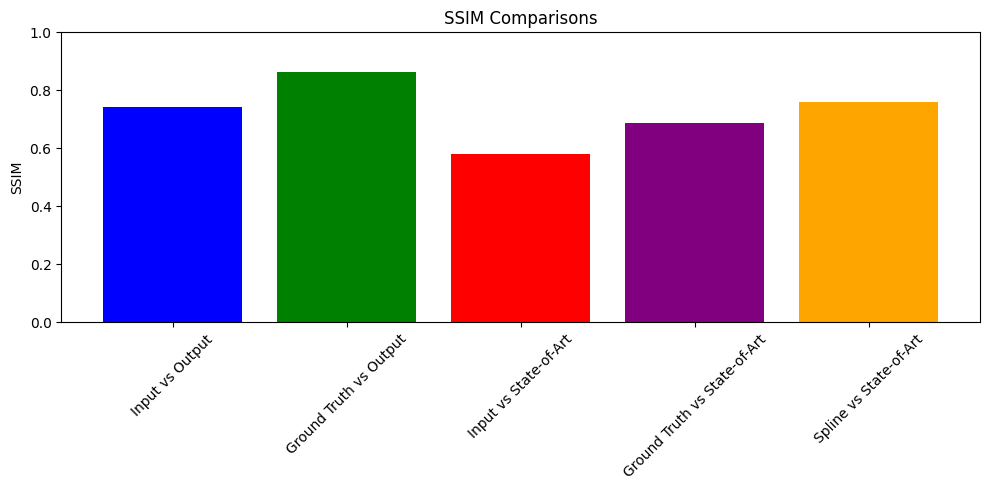

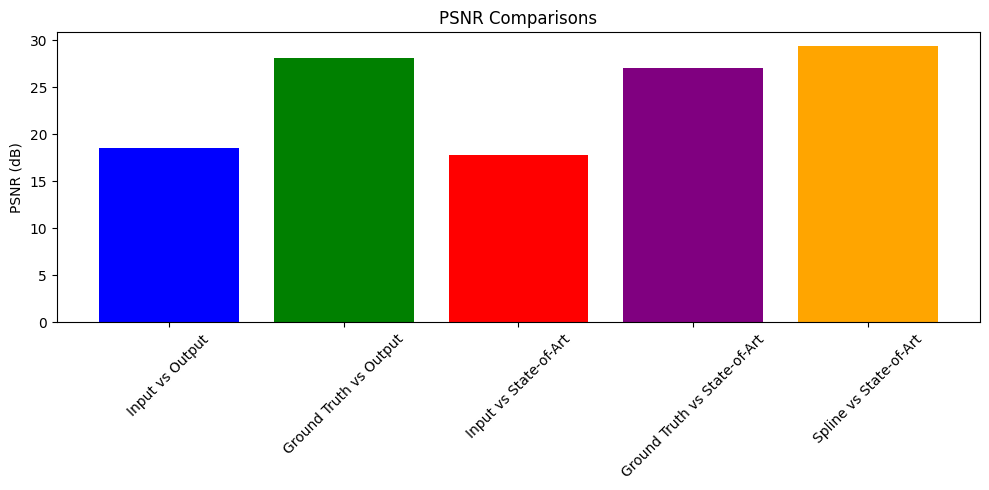

In [9]:
import matplotlib.pyplot as plt

# Metrics data (example values, replace with your actual data)
ssim_input_vs_output = 0.7427
psnr_input_vs_output = 18.60
ssim_ground_truth_vs_output = 0.8649
psnr_ground_truth_vs_output = 28.18
ssim_input_vs_state_of_art = 0.5798
psnr_input_vs_state_of_art = 17.86
ssim_ground_truth_vs_state_of_art = 0.6869
psnr_ground_truth_vs_state_of_art = 27.03
ssim_spline_vs_state_of_art = 0.7610
psnr_spline_vs_state_of_art = 29.39

# SSIM Comparisons
ssim_values = [ssim_input_vs_output, ssim_ground_truth_vs_output, ssim_input_vs_state_of_art, ssim_ground_truth_vs_state_of_art, ssim_spline_vs_state_of_art]
ssim_labels = ['Input vs Output', 'Ground Truth vs Output', 'Input vs State-of-Art', 'Ground Truth vs State-of-Art', 'Spline vs State-of-Art']

plt.figure(figsize=(10, 5))
plt.bar(ssim_labels, ssim_values, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylabel('SSIM')
plt.title('SSIM Comparisons')
plt.ylim(0, 1)  # SSIM ranges from -1 to 1, but typically we expect values between 0 and 1
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# PSNR Comparisons
psnr_values = [psnr_input_vs_output, psnr_ground_truth_vs_output, psnr_input_vs_state_of_art, psnr_ground_truth_vs_state_of_art, psnr_spline_vs_state_of_art]
psnr_labels = ['Input vs Output', 'Ground Truth vs Output', 'Input vs State-of-Art', 'Ground Truth vs State-of-Art', 'Spline vs State-of-Art']

plt.figure(figsize=(10, 5))
plt.bar(psnr_labels, psnr_values, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylabel('PSNR (dB)')
plt.title('PSNR Comparisons')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Print("Plots for Comparison of SSIM and PSNR for Different Data are created.")


## **Do Not Run the Below Chunk: This code is used to degrade the original data from 30 fps to 10 fps**

In [10]:
'''

from moviepy.editor import VideoFileClip

# Load the original video
original_clip = VideoFileClip('input.mp4')

# Extract the first minute of the video
first_minute_clip = original_clip.subclip(0, 15)  # Parameters are start time and end time in seconds
first_minute_clip.write_videofile('output.mp4', codec='libx264', audio_codec='aac')

# Reduce the frame rate of the extracted video to 10 fps
reduced_frame_rate_clip = first_minute_clip.set_fps(10)
reduced_frame_rate_clip.write_videofile('reduced_output.mp4', codec='libx264', audio_codec='aac')

# Close all clips to free up resources
original_clip.close()
first_minute_clip.close()
reduced_frame_rate_clip.close()

'''

"\n\nfrom moviepy.editor import VideoFileClip\n\n# Load the original video\noriginal_clip = VideoFileClip('input.mp4')\n\n# Extract the first minute of the video\nfirst_minute_clip = original_clip.subclip(0, 15)  # Parameters are start time and end time in seconds\nfirst_minute_clip.write_videofile('output.mp4', codec='libx264', audio_codec='aac')\n\n# Reduce the frame rate of the extracted video to 10 fps\nreduced_frame_rate_clip = first_minute_clip.set_fps(10)\nreduced_frame_rate_clip.write_videofile('reduced_output.mp4', codec='libx264', audio_codec='aac')\n\n# Close all clips to free up resources\noriginal_clip.close()\nfirst_minute_clip.close()\nreduced_frame_rate_clip.close()\n\n"